In [200]:
import sys 
import matplotlib.pyplot as plt
import pandas as pd 
import plotly.express as px
import json
import seaborn as sns
from datetime import datetime
from datasets import load_dataset ,Dataset
import tqdm as tqdm
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split ,KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

sys.path.append('./src/utils')
import general_utils as gu
from regression_utils import multi_one_hot_encode_columns, create_train_test_split, load_books_movies, merge_and_clean_sim, books_features_preprocessing

## Loading the Data

In [201]:
#Data set created in books movies cleaning
data = gu.load_final_dataset()

#Unique books is later used to plot different Authors so it contains only one row per book id 
unique_books = data[['length', 'book_id', 'BookTitle', 'Author', 'normalized_rating_y', 'BookYear', 'review_count']].drop_duplicates(subset='book_id')

#Dataset used for regression, prepared in books movies cleaning
regression_dataset_tmdb_raw_df = load_dataset("ada-datadruids/regression_dataset_tmdb")['train'].to_pandas()

## Data Visualization

### Scatter Plot to compare ratings of books and movies

In [202]:
labels={ 'normalized_rating_x': 'Normalized Movie Rating', 'normalized_rating_y': 'Normalized Book Rating'}
gu.px_scatter_plot(data,'normalized_rating_x','normalized_rating_y','movie_name', 'Movie Rating vs. Book Ratings', labels)

One can see that most book and movie ratings are around 0.6 which is around 3 stars in the standard 5 star rating system. This seem very reasonable. Additionally, there seems to be a positive correlation between book and movie ratings, which was expected.

### Book Length Distribution

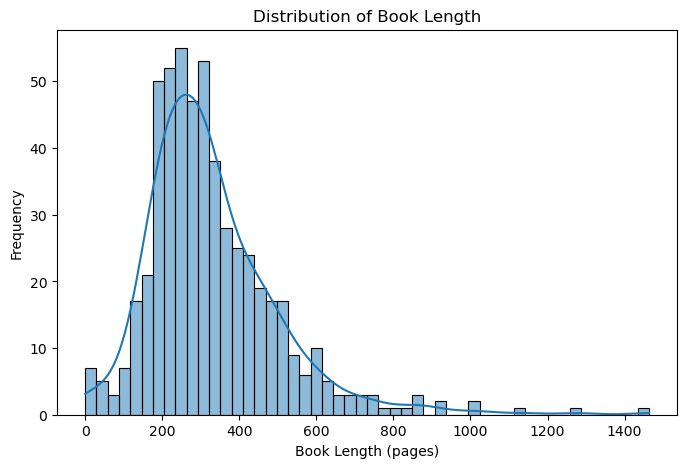

In [203]:

plt.figure(figsize=(8, 5))
sns.histplot(unique_books['length'], bins=50, kde=True)
plt.title('Distribution of Book Length')
plt.xlabel('Book Length (pages)')
plt.ylabel('Frequency')
plt.show()

This graph shows what one would expect, an average book is between 200 and 400 pages. This range is also present here which means that the data can be assumed correct on a first assumption.

### Comparison of Revenue with Book and Movie Ratings

In [204]:
labels = {'revenue': 'Movie Revenue ($), logscale', 'normalized_rating_y': 'Normalized Book Rating'}
gu.px_scatter_plot(data,'revenue','normalized_rating_y','movie_name', 'Revenue vs. Book Ratings', labels, width=900 ,xaxis_type="log")

This plot shows the general behaviour that movie revenue is slightly correlated with the book ratings.

In [205]:
# We want to check which movies are successful based on the two characteristics revenue and movie ratings. We will show four quadrants each containing about a quarter of movies. 
gu.quadrant_revenue(data, 'revenue', title='Revenue vs. Movie Ratings')

The four categories that have been defined are dependend on the median movie ratings and the median movie revenues. This gives four categories of movies measured on the success metrics that were defined in the project description. There may be some essential differences between movies in the different quadrants of this plot that should be investigated further.

### Revenue Adaptation for inflation
We use the same approach as discussed in this article: https://towardsdatascience.com/adjusting-prices-for-inflation-in-pandas-daaaa782cd89 

We use the data from here: https://fred.stlouisfed.org/series/CPIAUCNS 

In [206]:
df_revenue = gu.adjust_for_inflation(data, ['revenue','budget'],cpiaucns_path='./data/CPIAUCNS.csv' ,title='BookTitle', is_plotting_enabled=True)

With this inflation-adjustment trends can be visualized related to the cost of living at that momnent. This shows that the trend of increasing revenues is much less present than initially thought. Another thing that can be seen is the increase in movies at around 1980. After 1980 it seems that movies have a much harder time to make a lot of money. This may also arise because of a bias in the dataset which leads to only successful old movies being included.

### Let's plot the categories with Inflations-Adjustment

In [207]:
gu.quadrant_revenue(df_revenue, 'adjusted_revenue', title='Adjusted Revenue vs. Movie Ratings')

The inflation-adjustment has little impact on this particular plot. The main thing that can be seen is a shift to the right, so a general increase in revenues. Which comes from the fact that the inflation was adjusted to the value of today's money, rather than to the money from the past. 

### Top 10 Authors with the most different Books adapted into Movies

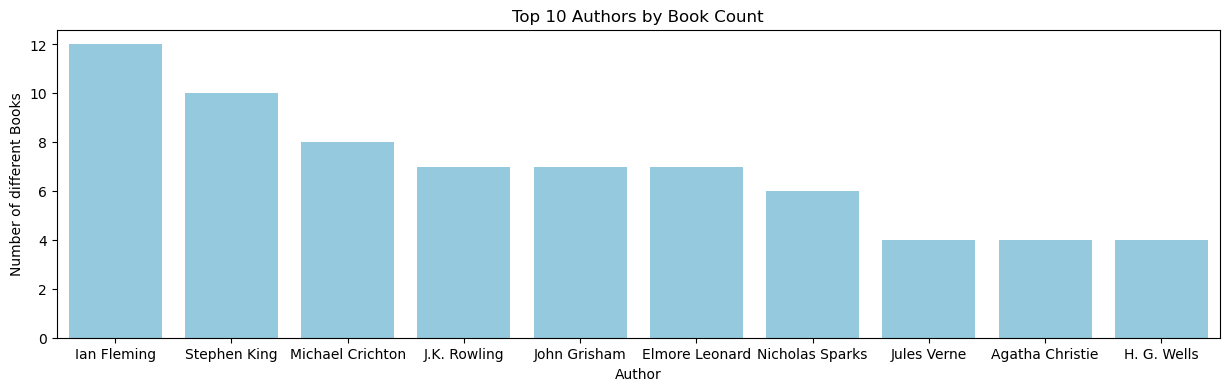

In [208]:
unique_books_author = unique_books[unique_books.Author != '0']
author_stats = unique_books_author.groupby('Author').agg(book_count=('BookTitle', 'size')).sort_values(by='book_count', ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(15, 4))
sns.barplot(x=author_stats.index, y=author_stats['book_count'], color='skyblue', ax=ax1)
ax1.set_ylabel('Number of different Books')
ax1.set_xlabel('Author')
ax1.set_title('Top 10 Authors by Book Count')
plt.show()

Zane Grey seems to have understood the way of writing books that are later made into movies. While he is mainly known for western movies, Ian Fleming has gotten to his spot by writing all the "James Bond" books. Stephen King is on a well deserved third place with all of his horror movies. This plot shows, that most authors that write books which are adapted often, only write for a very specific niche. This is a sort of winner takes it all effect, which means that in some genres there is one author that will probably have all his books turned into films while most other authors are overlooked.

### Release Year of the Book

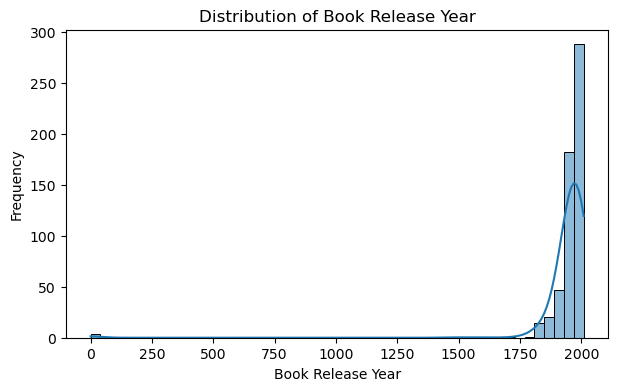

In [209]:
plt.figure(figsize=(7, 4))
sns.histplot(unique_books['BookYear'].dropna(), bins=50, kde=True)
plt.title('Distribution of Book Release Year')
plt.xlabel('Book Release Year')
plt.ylabel('Frequency')
plt.show()

In [210]:
display(unique_books[unique_books.BookYear <= 50])

,length,book_id,BookTitle,Author,normalized_rating_y,BookYear,review_count
692,224.0,25309336.0,The Rebel Outlaw: Josey Wales,Asa Earl Carter,0.686667,0,52.0
818,320.0,13109354.0,One Thousand and One Nights,0,0.596667,0,211.0
1337,541.0,1381.0,Odyssey,Homer,0.583333,0,9990.0
1370,213.0,52357.0,Beowulf,unknown,0.476667,0,5648.0


Some of these books are actually written a very long time ago (like Odyssey from Homer for example was written around 700 B.C.), but others just don't seem to have the correct year (like Background to Danger from 1937). Let's exclude them for now from the analysis, since they are only a few. 

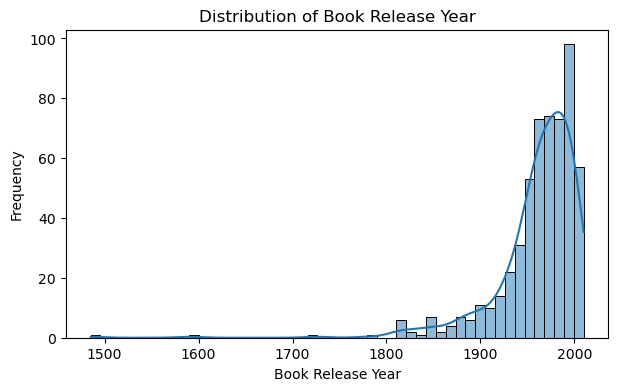

In [211]:
unique_books_year = unique_books[unique_books.BookYear != 0]
plt.figure(figsize=(7, 4))
sns.histplot(unique_books_year['BookYear'].dropna(), bins=50, kde=True)
plt.title('Distribution of Book Release Year')
plt.xlabel('Book Release Year')
plt.ylabel('Frequency')
plt.show()

Now the graph is more useful. Most books that were turned into movies were written in the 19th century. This mainly comes form an increase in book publishing since more people had the time and money to spend on writing. 

### How much time goes by between a Book and Movie Release?

In [212]:
year_book_movie = data.dropna(subset=['BookYear', 'movie_year'])
year_book_movie = year_book_movie[year_book_movie['BookYear']!=0]
year_book_movie['years_to_movie'] = year_book_movie['movie_year'] - year_book_movie['BookYear']


labels={'BookYear': 'Book Release Year', 'years_to_movie': 'Years to Movie Release'}
hover_data={'BookTitle': True, 'BookYear': True, 'movie_year': True, 'years_to_movie': True}
gu.px_scatter_plot(year_book_movie,'movie_year','years_to_movie','movie_name', 'Revenue vs. Book Ratings', labels, height=400, width=1200, update_traces=True, hover_data=hover_data)



There seems to be something weird going on for the Tarzan movies... After some quick research, we found out that while in 1995 the last written work for a Tarzan novel was found, the original books were released much sooner. 

### Summary Similarity Distribution

,movie_id,book_title,movie_name,book_summary,film_summary,similarity,film_sentiment,film_sentiment_score,book_sentiment,book_sentiment_score
0,196176,The Siege of Trencher's Farm,Straw Dogs,"George Magruder, an American professor of Eng...","David Sumner , a timid American mathematician,...",0.451876,positive,0.333608,positive,0.994480
1,6703617,Journey to the West,The Forbidden Kingdom,The novel has 100 chapters. These can be divi...,"In this film, which is based loosely on the an...",0.559594,positive,0.995482,positive,0.995404
2,24416479,The Beast Master,Beastmaster 2: Through the Portal of Time,"It tells the story of Hosteen Storm, an ex-so...","Dar, the Beastmaster , is back and now he has ...",0.344548,positive,0.997562,positive,0.998812
3,9384481,The Blessing,Count Your Blessings,It is set in the post-war World War II period...,While visiting Grace Allingham in wartime Lond...,0.669707,positive,0.996070,positive,0.996607
4,22224559,The Last Song,The Last Song,Veronica “Ronnie” Miller’s life was turned up...,"At seventeen, Veronica ""Ronnie"" Miller remain...",0.852735,positive,0.978184,positive,0.998164


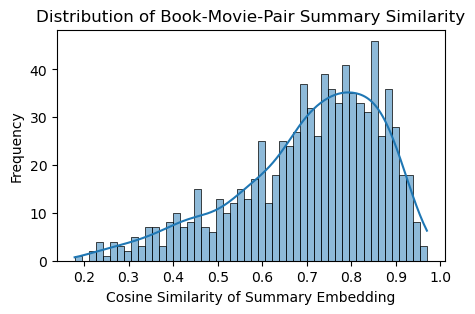

In [213]:
nlp_df = load_dataset("ada-datadruids/bookfilm_summaries_with_similarity_and_sentiment")['train'].to_pandas()
display(nlp_df.head(5))
plt.figure(figsize=(5, 3))
sns.histplot(nlp_df['similarity'], bins=50, kde=True)
plt.title('Distribution of Book-Movie-Pair Summary Similarity')
plt.xlabel('Cosine Similarity of Summary Embedding')
plt.ylabel('Frequency')
plt.show()


The summary similarity between books and movies is quite high. There are however also quite a few summaries where the movie and book seem to differ a lot. Which of these movie-book pairs performed better or worse have not yet been analysed, but there will surely be some interesting conclusions to make.

### Sentiment Analysis

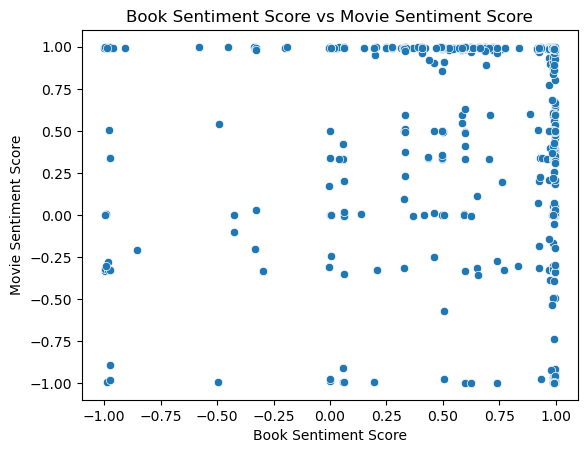

In [214]:
sns.scatterplot(x=nlp_df['book_sentiment_score'], y=nlp_df['film_sentiment_score'])

plt.xlabel('Book Sentiment Score')
plt.ylabel('Movie Sentiment Score')

plt.title('Book Sentiment Score vs Movie Sentiment Score')
plt.show()

This plot has no visual correlations between book and movie sentiment scores. One would expect to have quite a clear correlation of the movies were direct adaptations of the books, since this is not the case, some further investigation is needed.

## Linear Regression 

### Create Datasets for the following steps

In [215]:
print(regression_dataset_tmdb_raw_df['based_on_book'].value_counts())
regression_dataset_tmdb_raw_df = gu.adjust_for_inflation(regression_dataset_tmdb_raw_df, ['budget', 'revenue'], is_plotting_enabled=False)

based_on_book
False    7694
True      659
Name: count, dtype: int64


In [216]:
# Drop the columns that are not relevant for the regression, drop revenue and budget,
# because in the previous step two new columns have been added: adjusted revenue and adjusted budget 
# production companies removed as there are over 100'000 unique values
regression_dataset_tmdb_raw_df.drop(columns=['keywords', 'release_date', 'backdrop_path', 'homepage', 'original_title', 'overview', 'poster_path', 'tagline', 'production_companies', 'original_language','budget', 'imdb_id'], inplace=True)

matching_dataset_processed_df = multi_one_hot_encode_columns(
    regression_dataset_tmdb_raw_df,
    column_names_mohe=['genres', 'spoken_languages', 'production_countries'], # keywords not taken for now
    column_names_ohe=['status'],
)

# Keep the id in the matching dataset, which will be used later for the matching step, the id is not used for the scatter plot 
scatter_plot_data_regression_dataset_df= matching_dataset_processed_df.drop(columns=['id'])

#The title is used for scatter plot but not for regression, therefore we should drop it in addition to the id 
regression_dataset_processed_df=scatter_plot_data_regression_dataset_df.drop(columns=['title'])

#Drop the title form the matching dataset but keep the id, this will be used for the last regression done in this notebook
#The dataset is already created here, because we need the multi one hot encoding, but not the title, but we have to keep the id for merging 
final_regression_dataset = matching_dataset_processed_df.drop(columns=['title'])

### Find Relation Between Budget and Revenue

In [217]:

labels={'adjusted_budget': 'Budget', 'adjusted_revenue': 'Revenue'}
gu.px_scatter_plot(scatter_plot_data_regression_dataset_df,'adjusted_budget','adjusted_revenue','title', 'Budget vs Revenue', labels,height=650,xaxis_type='log', yaxis_type='log')


In [218]:
# Create a new column for the revenue/budget ratio
scatter_plot_data_regression_dataset_df['revenue_to_budget_ratio'] = (
    scatter_plot_data_regression_dataset_df['adjusted_revenue'] / scatter_plot_data_regression_dataset_df['adjusted_budget']
)

labels={'adjusted_budget': 'Budget', 'revenue_to_budget_ratio': 'Revenue-to-Budget Ratio'}
# Create a scatter plot of revenue/budget ratio vs budget
gu.px_scatter_plot(scatter_plot_data_regression_dataset_df,'adjusted_budget','revenue_to_budget_ratio','title', 'Revenue-to-Budget Ratio vs Budget', labels,height=650,xaxis_type='log', yaxis_type='log')

### Dataset Split

First the Dataset is split in two different ways, according to if movies based on books are analysed separate from movies not based on books

First Split:
- Case 1: Take the whole dataset, don't separate based on book and not basekd on book 

Second Split: 
- Case 2: Only consider Movies based on Books
- Case 3: Only consider Movies not based on Books

In [219]:
# Standardise and split the dataset into train and test set taking into account movies based on books and movies not based on books 
X_train, X_test, y_train, y_test = create_train_test_split(
    regression_dataset_processed_df, 
    target_column='adjusted_revenue', 
    should_split_based_on_book=False, 
    test_size=0.2, 
    seed=42
)['all']

'''
Because the flag should_split_based_on_book is set to True in the function create_train_test_split, the dataset will 
first be separated into BOBs and NOBs. This assures that the resulting test and train data sets will have the 
specified sizes for each part of the dataset resepectively . 
'''
#Standardise and Split Dataset into train on test set according to if movies are based on book or not 
split_dict = create_train_test_split(
    regression_dataset_processed_df,
    target_column='adjusted_revenue',
    should_split_based_on_book=True,
    test_size=0.2,
    seed=42
)
X_train_based_on_book, X_test_based_on_book, y_train_based_on_book, y_test_based_on_book = split_dict['based_on_book']
X_train_not_based_on_book, X_test_not_based_on_book, y_train_not_based_on_book, y_test_not_based_on_book = split_dict['not_based_on_book']

### Revenue Approach

#### Non Separated (based on book or not)

#### Without budget

In [220]:
model = sm.OLS(y_train, X_train.drop(columns=['adjusted_budget']))
results = model.fit()
y_pred = results.predict(X_test.drop(columns=['adjusted_budget']))
rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
print("RMSE value:", rmse)
results.summary()

RMSE value: 128329405.23467857


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     280.7
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:09:38   Log-Likelihood:            -1.3346e+05
No. Observations:                6675   AIC:                         2.670e+05
Df Residuals:                    6625   BIC:                         2.674e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                          8.612e+07   1.43e+06     60.039      0.000    8.33e+07    8.89e+07
vote_average                                   2.324e+06   1.66e+06      1.397      0.163   -9.38e+05    5.59e+06
vote_count                                    -5.366e+06   2.67e+06     -2.007      0.045   -1.06e+07   -1.25e+05
revenue                                        1.619e+08   2.35e+06     68.991      0.000    1.57e+08    1.67e+08
runtime                                        1.096e+07    1.8e+06      6.103      0.000    7.44e+06    1.45e+07
adult                                          2.199e+06   1.44e+06      1.522      0.128   -6.33e+05    5.03e+06
popularity                                     1.436e+07   2.29e+06      6.274      0.000    9.87e+06    1.88e+07
based_on_book                                  8.231e+06   1.51e+06      5.437      0.000    5.26e+06    1.12e+07
movie_year                                    -3.333e+07   1.61e+06    -20.682      0.000   -3.65e+07   -3.02e+07
genres_count                                   -7.52e+06   1.12e+07     -0.670      0.503   -2.95e+07    1.45e+07
genres_Action                                  3.704e+06   4.61e+06      0.803      0.422   -5.34e+06    1.27e+07
genres_Adventure                               1.503e+06   4.16e+06      0.362      0.718   -6.65e+06    9.65e+06
genres_Animation                                4.73e+06   2.84e+06      1.667      0.096   -8.33e+05    1.03e+07
genres_Comedy                                  1.474e+06   5.11e+06      0.289      0.773   -8.53e+06    1.15e+07
genres_Crime                                  -5.514e+05   3.97e+06     -0.139      0.889   -8.33e+06    7.22e+06
genres_Documentary                             2.606e+06   2.08e+06      1.252      0.211   -1.47e+06    6.69e+06
genres_Drama                                   2.624e+06   5.37e+06      0.489      0.625    -7.9e+06    1.31e+07
genres_Family                                  5.536e+06   3.42e+06      1.619      0.105   -1.17e+06    1.22e+07
genres_Fantasy                                -1.621e+06   3.16e+06     -0.514      0.608   -7.81e+06    4.57e+06
genres_History                                -1.184e+06   2.58e+06     -0.459      0.647   -6.24e+06    3.88e+06
genres_Horror                                  1.506e+06   3.44e+06      0.438      0.661   -5.23e+06    8.25e+06
genres_Music                                   5.811e+05   2.54e+06      0.229      0.819   -4.39e+06    5.55e+06
genres_Mystery                                -5.699e+05   3.12e+06     -0.183      0.855   -6.69e+06    5.55e+06
genres_Romance                                 2.724e+06   4.35e+06      0.626      0.532   -5.81e+06    1.13e+07
genre

#### With Budget 

In [221]:
model = sm.OLS(y_train, X_train)
results = model.fit()
y_pred = results.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
print("RMSE value:", rmse)

results.summary()

RMSE value: 135055071.5583833


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     277.2
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:09:38   Log-Likelihood:            -1.3345e+05
No. Observations:                6675   AIC:                         2.670e+05
Df Residuals:                    6624   BIC:                         2.673e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                          8.612e+07   1.43e+06     60.197      0.000    8.33e+07    8.89e+07
vote_average                                   1.627e+06   1.66e+06      0.978      0.328   -1.63e+06    4.89e+06
vote_count                                    -6.526e+06   2.67e+06     -2.441      0.015   -1.18e+07   -1.28e+06
revenue                                        1.697e+08   2.68e+06     63.414      0.000    1.64e+08    1.75e+08
runtime                                        1.245e+07   1.81e+06      6.886      0.000     8.9e+06     1.6e+07
adult                                          2.057e+06   1.44e+06      1.427      0.154   -7.68e+05    4.88e+06
popularity                                     1.562e+07   2.29e+06      6.816      0.000    1.11e+07    2.01e+07
based_on_book                                  8.902e+06   1.51e+06      5.880      0.000    5.93e+06    1.19e+07
movie_year                                    -3.287e+07   1.61e+06    -20.432      0.000    -3.6e+07   -2.97e+07
adjusted_budget                               -1.377e+07    2.3e+06     -5.987      0.000   -1.83e+07   -9.26e+06
genres_count                                  -6.394e+06   1.12e+07     -0.571      0.568   -2.83e+07    1.56e+07
genres_Action                                   4.25e+06    4.6e+06      0.924      0.356   -4.77e+06    1.33e+07
genres_Adventure                               2.348e+06   4.15e+06      0.566      0.571   -5.78e+06    1.05e+07
genres_Animation                               4.777e+06   2.83e+06      1.688      0.091   -7.71e+05    1.03e+07
genres_Comedy                                  9.439e+05   5.09e+06      0.185      0.853   -9.04e+06    1.09e+07
genres_Crime                                  -9.538e+05   3.96e+06     -0.241      0.809   -8.71e+06     6.8e+06
genres_Documentary                             2.025e+06   2.08e+06      0.974      0.330   -2.05e+06     6.1e+06
genres_Drama                                   1.666e+06   5.36e+06      0.311      0.756   -8.83e+06    1.22e+07
genres_Family                                  5.637e+06   3.41e+06      1.653      0.098   -1.05e+06    1.23e+07
genres_Fantasy                                -1.137e+06   3.15e+06     -0.361      0.718   -7.31e+06    5.04e+06
genres_History                                -7.706e+05   2.58e+06     -0.299      0.765   -5.82e+06    4.28e+06
genres_Horror                                  1.732e+05   3.44e+06      0.050      0.960   -6.56e+06    6.91e+06
genres_Music                                   4.032e+05   2.53e+06      0.159      0.873   -4.56e+06    5.36e+06
genres_Mystery                                 -6.63e+05   3.11e+06     -0.213      0.831   -6.77e+06    5.44e+06
genre

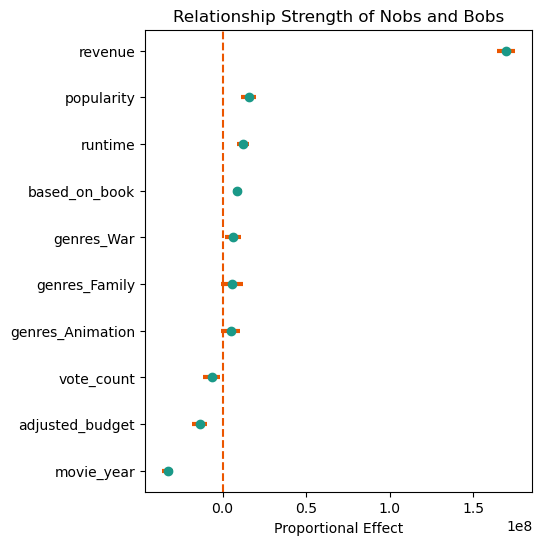

In [222]:
gu.plot_regression(results,"Relationship Strength of Nobs and Bobs")

### Separated (Based on Books or not)

### Without Budget 

In [223]:
model = sm.OLS(y_train_based_on_book, X_train_based_on_book.drop(columns=['adjusted_budget']))
results = model.fit()
y_pred = results.predict(X_test_based_on_book.drop(columns=['adjusted_budget']))
rmse = np.sqrt(mean_squared_error(y_true=y_test_based_on_book, y_pred=y_pred))
print("RMSE value:", rmse)

results.summary()

RMSE value: 570563246.7975541


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     37.93
Date:                Thu, 19 Dec 2024   Prob (F-statistic):          5.64e-131
Time:                        19:09:39   Log-Likelihood:                -10511.
No. Observations:                 526   AIC:                         2.112e+04
Df Residuals:                     479   BIC:                         2.132e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                          1.719e+08   5.27e+06     32.606      0.000    1.62e+08    1.82e+08
vote_average                                   7.612e+06    7.5e+06      1.015      0.311   -7.12e+06    2.23e+07
vote_count                                     9.233e+05   1.13e+07      0.082      0.935   -2.13e+07    2.32e+07
revenue                                        1.971e+08   9.71e+06     20.303      0.000    1.78e+08    2.16e+08
runtime                                        2.374e+07   7.35e+06      3.229      0.001    9.29e+06    3.82e+07
adult                                          -1.08e-07   2.88e-08     -3.753      0.000   -1.65e-07   -5.15e-08
popularity                                     2.705e+07   9.92e+06      2.728      0.007    7.57e+06    4.65e+07
movie_year                                    -6.003e+07   6.52e+06     -9.212      0.000   -7.28e+07   -4.72e+07
genres_count                                  -4.231e+07   3.39e+07     -1.250      0.212   -1.09e+08    2.42e+07
genres_Action                                  3.033e+07   1.55e+07      1.952      0.052   -2.08e+05    6.09e+07
genres_Adventure                               3.303e+07   1.74e+07      1.897      0.058   -1.18e+06    6.72e+07
genres_Animation                               2.081e+07   1.03e+07      2.021      0.044    5.78e+05     4.1e+07
genres_Comedy                                  2.534e+07    1.4e+07      1.806      0.072   -2.23e+06    5.29e+07
genres_Crime                                   7.736e+06   1.34e+07      0.576      0.565   -1.86e+07    3.41e+07
genres_Documentary                             -1.98e-08   1.85e-08     -1.070      0.285   -5.62e-08    1.66e-08
genres_Drama                                   1.142e+07   1.83e+07      0.623      0.533   -2.46e+07    4.74e+07
genres_Family                                  2.393e+07   1.34e+07      1.782      0.075   -2.46e+06    5.03e+07
genres_Fantasy                                -6.343e+06   1.31e+07     -0.484      0.629   -3.21e+07    1.94e+07
genres_History                                 3.172e+05   9.59e+06      0.033      0.974   -1.85e+07    1.92e+07
genres_Horror                                   1.79e+07   1.17e+07      1.529      0.127   -5.11e+06    4.09e+07
genres_Music                                   8.244e+05   6.67e+06      0.124      0.902   -1.23e+07    1.39e+07
genres_Mystery                                 2.094e+05   1.26e+07      0.017      0.987   -2.46e+07     2.5e+07
genres_Romance                                 1.787e+07   1.53e+07      1.167      0.244   -1.22e+07     4.8e+07
genres_Science Fiction                        -1.676e+06   1.26e+07     -0.134      0.894   -2.63e+07     2.3e+07
genre

#### With Budget

In [224]:
model = sm.OLS(y_train_based_on_book, X_train_based_on_book)
results = model.fit()

y_pred = results.predict(X_test_based_on_book)
rmse = np.sqrt(mean_squared_error(y_true=y_test_based_on_book, y_pred=y_pred))
print("RMSE value:", rmse)

results.summary()

RMSE value: 569759104.8200053


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     37.15
Date:                Thu, 19 Dec 2024   Prob (F-statistic):          2.06e-130
Time:                        19:09:39   Log-Likelihood:                -10510.
No. Observations:                 526   AIC:                         2.112e+04
Df Residuals:                     478   BIC:                         2.132e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                          1.719e+08   5.27e+06     32.608      0.000    1.62e+08    1.82e+08
vote_average                                   6.051e+06   7.65e+06      0.791      0.429   -8.98e+06    2.11e+07
vote_count                                    -2.896e+05   1.14e+07     -0.025      0.980   -2.26e+07    2.21e+07
revenue                                         2.02e+08   1.08e+07     18.712      0.000    1.81e+08    2.23e+08
runtime                                        2.541e+07   7.52e+06      3.376      0.001    1.06e+07    4.02e+07
adult                                         -1.574e-07    1.1e-07     -1.437      0.151   -3.73e-07    5.78e-08
popularity                                      2.79e+07   9.95e+06      2.804      0.005    8.35e+06    4.74e+07
movie_year                                    -5.893e+07    6.6e+06     -8.927      0.000   -7.19e+07    -4.6e+07
adjusted_budget                               -8.479e+06   8.14e+06     -1.041      0.298   -2.45e+07    7.52e+06
genres_count                                  -4.218e+07   3.39e+07     -1.246      0.213   -1.09e+08    2.43e+07
genres_Action                                  3.056e+07   1.55e+07      1.966      0.050     1.4e+04    6.11e+07
genres_Adventure                               3.349e+07   1.74e+07      1.923      0.055   -7.23e+05    6.77e+07
genres_Animation                               2.137e+07   1.03e+07      2.072      0.039    1.11e+06    4.16e+07
genres_Comedy                                  2.511e+07    1.4e+07      1.789      0.074   -2.46e+06    5.27e+07
genres_Crime                                   8.025e+06   1.34e+07      0.598      0.550   -1.84e+07    3.44e+07
genres_Documentary                            -5.643e-08   2.21e-08     -2.549      0.011   -9.99e-08   -1.29e-08
genres_Drama                                   1.144e+07   1.83e+07      0.625      0.533   -2.45e+07    4.74e+07
genres_Family                                  2.461e+07   1.34e+07      1.830      0.068   -1.81e+06     5.1e+07
genres_Fantasy                                -5.895e+06   1.31e+07     -0.449      0.653   -3.17e+07    1.99e+07
genres_History                                 7.749e+05    9.6e+06      0.081      0.936   -1.81e+07    1.96e+07
genres_Horror                                  1.771e+07   1.17e+07      1.512      0.131   -5.31e+06    4.07e+07
genres_Music                                   1.063e+06   6.67e+06      0.159      0.873    -1.2e+07    1.42e+07
genres_Mystery                                 2.518e+05   1.26e+07      0.020      0.984   -2.46e+07    2.51e+07
genres_Romance                                 1.741e+07   1.53e+07      1.137      0.256   -1.27e+07    4.75e+07
genre

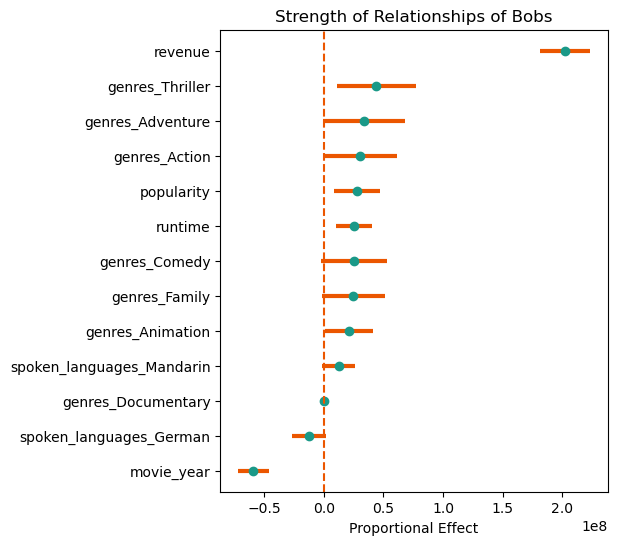

In [225]:
gu.plot_regression(results, "Strength of Relationships of Bobs")

### Movies not Based on Books Without Budget

In [226]:
model = sm.OLS(y_train_not_based_on_book, X_train_not_based_on_book.drop(columns=['adjusted_budget']))
results = model.fit()

y_pred = results.predict(X_test_not_based_on_book.drop(columns=['adjusted_budget']))
rmse = np.sqrt(mean_squared_error(y_true=y_test_not_based_on_book, y_pred=y_pred))
print("RMSE value:", rmse)
results.summary()

RMSE value: 71064090.875081


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     334.3
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:09:39   Log-Likelihood:            -1.2173e+05
No. Observations:                6148   AIC:                         2.436e+05
Df Residuals:                    6099   BIC:                         2.439e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                          7.628e+07   1.23e+06     61.982      0.000    7.39e+07    7.87e+07
vote_average                                   2.505e+06   1.43e+06      1.754      0.079   -2.95e+05     5.3e+06
vote_count                                     -3.75e+06   2.24e+06     -1.672      0.095   -8.15e+06    6.47e+05
revenue                                        1.514e+08   1.96e+06     77.144      0.000    1.48e+08    1.55e+08
runtime                                        5.087e+06   1.64e+06      3.102      0.002    1.87e+06     8.3e+06
adult                                          2.124e+06   1.24e+06      1.716      0.086   -3.02e+05    4.55e+06
popularity                                     1.161e+07   1.93e+06      6.010      0.000    7.82e+06    1.54e+07
movie_year                                    -2.946e+07   1.36e+06    -21.712      0.000   -3.21e+07   -2.68e+07
genres_count                                   -3.03e+06   9.41e+06     -0.322      0.748   -2.15e+07    1.54e+07
genres_Action                                  7.586e+04   3.89e+06      0.020      0.984   -7.55e+06     7.7e+06
genres_Adventure                              -1.629e+06   3.37e+06     -0.483      0.629   -8.24e+06    4.99e+06
genres_Animation                               4.503e+06   2.42e+06      1.859      0.063   -2.45e+05    9.25e+06
genres_Comedy                                 -1.154e+06   4.34e+06     -0.266      0.790   -9.66e+06    7.35e+06
genres_Crime                                   2.506e+05   3.37e+06      0.074      0.941   -6.36e+06    6.86e+06
genres_Documentary                             1.457e+06   1.83e+06      0.796      0.426   -2.13e+06    5.04e+06
genres_Drama                                  -3.459e+05   4.51e+06     -0.077      0.939   -9.19e+06    8.49e+06
genres_Family                                  3.134e+06   2.82e+06      1.112      0.266   -2.39e+06    8.66e+06
genres_Fantasy                                -2.427e+05   2.59e+06     -0.094      0.925   -5.32e+06    4.83e+06
genres_History                                -9.925e+04   2.21e+06     -0.045      0.964   -4.44e+06    4.24e+06
genres_Horror                                  -1.18e+06   2.98e+06     -0.396      0.692   -7.03e+06    4.67e+06
genres_Music                                  -2.324e+06    2.2e+06     -1.055      0.292   -6.64e+06       2e+06
genres_Mystery                                -1.042e+06   2.56e+06     -0.407      0.684   -6.06e+06    3.98e+06
genres_Romance                                 6.185e+05   3.68e+06      0.168      0.866   -6.59e+06    7.82e+06
genres_Science Fiction                         1.652e+06   2.72e+06      0.607      0.544   -3.69e+06    6.99e+06
genre

### Movies Based on Books with Budget

In [227]:
model = sm.OLS(y_train_not_based_on_book, X_train_not_based_on_book)
results = model.fit()

y_pred = results.predict(X_test_not_based_on_book)
rmse = np.sqrt(mean_squared_error(y_true=y_test_not_based_on_book, y_pred=y_pred))
print("RMSE value:", rmse)
results.summary()

RMSE value: 73848287.83348803


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     344.6
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:09:40   Log-Likelihood:            -1.2162e+05
No. Observations:                6148   AIC:                         2.433e+05
Df Residuals:                    6098   BIC:                         2.437e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                          7.628e+07   1.21e+06     63.145      0.000    7.39e+07    7.86e+07
vote_average                                   3.619e+06    1.4e+06      2.578      0.010    8.67e+05    6.37e+06
vote_count                                     -1.03e+06   2.21e+06     -0.466      0.641   -5.36e+06     3.3e+06
revenue                                        1.365e+08   2.16e+06     63.241      0.000    1.32e+08    1.41e+08
runtime                                        1.654e+06   1.63e+06      1.018      0.309   -1.53e+06    4.84e+06
adult                                          2.408e+06   1.22e+06      1.981      0.048    2.52e+04    4.79e+06
popularity                                     9.473e+06    1.9e+06      4.982      0.000    5.75e+06    1.32e+07
movie_year                                    -2.957e+07   1.33e+06    -22.203      0.000   -3.22e+07    -2.7e+07
adjusted_budget                                2.687e+07   1.76e+06     15.230      0.000    2.34e+07    3.03e+07
genres_count                                  -5.073e+06   9.24e+06     -0.549      0.583   -2.32e+07     1.3e+07
genres_Action                                 -8.328e+05   3.82e+06     -0.218      0.827   -8.32e+06    6.65e+06
genres_Adventure                              -3.363e+06   3.31e+06     -1.015      0.310   -9.86e+06    3.13e+06
genres_Animation                               4.585e+06   2.38e+06      1.928      0.054   -7.59e+04    9.25e+06
genres_Comedy                                 -8.599e+04   4.26e+06     -0.020      0.984   -8.44e+06    8.26e+06
genres_Crime                                   8.075e+05   3.31e+06      0.244      0.807   -5.68e+06     7.3e+06
genres_Documentary                             2.453e+06    1.8e+06      1.364      0.173   -1.07e+06    5.98e+06
genres_Drama                                   1.558e+06   4.43e+06      0.352      0.725   -7.12e+06    1.02e+07
genres_Family                                  2.984e+06   2.77e+06      1.079      0.281   -2.44e+06    8.41e+06
genres_Fantasy                                -1.104e+06   2.54e+06     -0.434      0.664   -6.09e+06    3.88e+06
genres_History                                -6.673e+05   2.17e+06     -0.307      0.759   -4.93e+06    3.59e+06
genres_Horror                                  1.394e+06   2.93e+06      0.475      0.634   -4.35e+06    7.14e+06
genres_Music                                  -1.841e+06   2.16e+06     -0.851      0.395   -6.08e+06     2.4e+06
genres_Mystery                                -9.056e+05   2.51e+06     -0.360      0.719   -5.83e+06    4.02e+06
genres_Romance                                 1.616e+06   3.61e+06      0.448      0.654   -5.46e+06    8.69e+06
genre

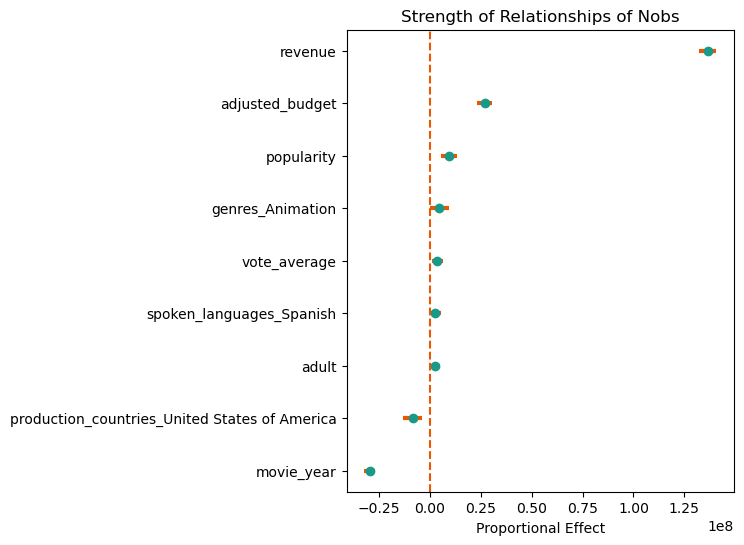

In [228]:
gu.plot_regression(results, "Strength of Relationships of Nobs")

### Revenue-Budget Fraction Approach

In [229]:
#Instead of predicting Revenue, the y value will be Revenue divided by Budget
regression_dataset_processed_rb_ration_df = regression_dataset_processed_df.copy(deep=True)

# ensure that log is defined and we do not divide by 0 later
regression_dataset_processed_rb_ration_df['adjusted_revenue'] = regression_dataset_processed_rb_ration_df['adjusted_revenue'].clip(lower=1e-10)
regression_dataset_processed_rb_ration_df['adjusted_budget'] = regression_dataset_processed_rb_ration_df['adjusted_budget'].clip(lower=1e-10)

regression_dataset_processed_rb_ration_df.loc[regression_dataset_processed_rb_ration_df['adjusted_budget'] == 1, 'adjusted_budget'] = 1 + 1e-10

regression_dataset_processed_rb_ration_df['log_rb_ratio'] = np.log(regression_dataset_processed_rb_ration_df['adjusted_revenue']) / np.log(regression_dataset_processed_rb_ration_df['adjusted_budget'])
print("min ratio:", regression_dataset_processed_rb_ration_df['log_rb_ratio'].min())
print("max ratio:", regression_dataset_processed_rb_ration_df['log_rb_ratio'].max())

regression_dataset_processed_rb_ration_df.drop(columns=['adjusted_revenue', 'adjusted_budget'], inplace=True)

X_train_rbf, X_test_rbf, y_train_rbf, y_test_rbf = create_train_test_split(
    regression_dataset_processed_rb_ration_df,
    target_column='log_rb_ratio',
    should_split_based_on_book=False,
    test_size=0.2,
    seed=42
)['all']

min ratio: -9.206662475599046
max ratio: 485.0724784969183


### Fit model on entire Dataset

In [230]:
model = sm.OLS(y_train_rbf, X_train_rbf)
results = model.fit()

y_pred_rbf = results.predict(X_test_rbf)
rmse = np.sqrt(mean_squared_error(y_true=y_test_rbf, y_pred=y_pred_rbf))
print("RMSE value:", rmse)
results.summary()

RMSE value: 1.7126509535847216


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.308
Date:                Thu, 19 Dec 2024   Prob (F-statistic):             0.0732
Time:                        19:09:40   Log-Likelihood:                -21683.
No. Observations:                6675   AIC:                         4.347e+04
Df Residuals:                    6625   BIC:                         4.381e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             1.1574      0.077     15.120      0.000       1.007       1.307
vote_average                                      0.0996      0.089      1.121      0.262      -0.075       0.274
vote_count                                        0.0463      0.143      0.324      0.746      -0.233       0.326
revenue                                           0.0132      0.125      0.105      0.916      -0.232       0.259
runtime                                          -0.0773      0.096     -0.807      0.420      -0.265       0.111
adult                                             0.3225      0.077      4.182      0.000       0.171       0.474
popularity                                       -0.1196      0.122     -0.980      0.327      -0.359       0.120
based_on_book                                     0.0307      0.081      0.380      0.704      -0.128       0.189
movie_year                                        0.0971      0.086      1.129      0.259      -0.071       0.266
genres_count                                     -0.2535      0.599     -0.423      0.672      -1.428       0.921
genres_Action                                     0.0822      0.246      0.334      0.738      -0.400       0.565
genres_Adventure                                  0.0457      0.222      0.206      0.837      -0.389       0.481
genres_Animation                                 -0.0031      0.151     -0.020      0.984      -0.300       0.294
genres_Comedy                                     0.2243      0.272      0.823      0.410      -0.310       0.758
genres_Crime                                      0.0348      0.212      0.164      0.869      -0.380       0.450
genres_Documentary                               -0.0102      0.111     -0.092      0.927      -0.228       0.208
genres_Drama                                      0.0630      0.286      0.220      0.826      -0.499       0.625
genres_Family                                     0.0882      0.182      0.483      0.629      -0.269       0.446
genres_Fantasy                                    0.0264      0.168      0.157      0.875      -0.304       0.357
genres_History                                    0.0449      0.138      0.326      0.745      -0.225       0.315
genres_Horror                                     0.0974      0.183      0.531      0.596      -0.262       0.457
genres_Music                                      0.0363      0.135      0.268      0.789      -0.229       0.302
genres_Mystery                                    0.0571      0.167      0.343      0.732      -0.269       0.384
genres_Romance                                    0.0559      0.232      0.240      0.810      -0.400       0.511
genre

### Separate movies in dataset according to if they are based on books or not 

In [231]:
dict = create_train_test_split(
    regression_dataset_processed_rb_ration_df,
    target_column='log_rb_ratio',
    should_split_based_on_book=True,
    test_size=0.2,
    seed=42
)
X_train_BOB_rbf, X_test_BOB_rbf, y_train_BOB_rbf, y_test_BOB_rbf = dict['based_on_book']
X_train_NOB_rbf, X_test_NOB_rbf, y_train_NOB_rbf, y_test_NOB_rbf = dict[
    'not_based_on_book']

#### Fit model for Movies Based on Book

In [232]:
model = sm.OLS(y_train_BOB_rbf, X_train_BOB_rbf)
results = model.fit()

y_pred_rbf = results.predict(X_test_BOB_rbf)
rmse = np.sqrt(mean_squared_error(y_true=y_test_BOB_rbf, y_pred=y_pred_rbf))
print("RMSE value:", rmse)

results.summary()

RMSE value: 0.11649835349644183


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1.753
Date:                Thu, 19 Dec 2024   Prob (F-statistic):            0.00231
Time:                        19:09:41   Log-Likelihood:                 115.86
No. Observations:                 526   AIC:                            -137.7
Df Residuals:                     479   BIC:                             62.75
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             1.0516      0.009    118.555      0.000       1.034       1.069
vote_average                                      0.0264      0.013      2.093      0.037       0.002       0.051
vote_count                                       -0.0113      0.019     -0.595      0.552      -0.049       0.026
revenue                                           0.0354      0.016      2.168      0.031       0.003       0.067
runtime                                          -0.0238      0.012     -1.928      0.054      -0.048       0.000
adult                                         -2.359e-17   4.84e-17     -0.487      0.626   -1.19e-16    7.15e-17
popularity                                       -0.0046      0.017     -0.277      0.782      -0.037       0.028
movie_year                                       -0.0225      0.011     -2.056      0.040      -0.044      -0.001
genres_count                                     -0.0416      0.057     -0.731      0.465      -0.154       0.070
genres_Action                                     0.0098      0.026      0.376      0.707      -0.042       0.061
genres_Adventure                                  0.0187      0.029      0.639      0.523      -0.039       0.076
genres_Animation                                  0.0076      0.017      0.440      0.660      -0.026       0.042
genres_Comedy                                     0.0135      0.024      0.571      0.568      -0.033       0.060
genres_Crime                                      0.0123      0.023      0.547      0.585      -0.032       0.057
genres_Documentary                            -1.044e-17   3.11e-17     -0.336      0.737   -7.16e-17    5.07e-17
genres_Drama                                      0.0276      0.031      0.895      0.371      -0.033       0.088
genres_Family                                     0.0066      0.023      0.294      0.769      -0.038       0.051
genres_Fantasy                                   -0.0005      0.022     -0.021      0.983      -0.044       0.043
genres_History                                    0.0035      0.016      0.220      0.826      -0.028       0.035
genres_Horror                                     0.0093      0.020      0.473      0.636      -0.029       0.048
genres_Music                                      0.0053      0.011      0.475      0.635      -0.017       0.027
genres_Mystery                                    0.0022      0.021      0.103      0.918      -0.040       0.044
genres_Romance                                    0.0059      0.026      0.230      0.818      -0.045       0.057
genres_Science Fiction                            0.0073      0.021      0.348      0.728      -0.034       0.049
genre

#### Fit Model for Movies Not based on book

In [233]:
model = sm.OLS(y_train_NOB_rbf, X_train_NOB_rbf)
results = model.fit()


y_pred_rbf = results.predict(X_test_NOB_rbf)
rmse = np.sqrt(mean_squared_error(y_true=y_test_NOB_rbf, y_pred=y_pred_rbf))
print("RMSE value:", rmse)
results.summary()

RMSE value: 2.474220779157735


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.550
Date:                Thu, 19 Dec 2024   Prob (F-statistic):            0.00894
Time:                        19:09:41   Log-Likelihood:                -20174.
No. Observations:                6148   AIC:                         4.045e+04
Df Residuals:                    6099   BIC:                         4.077e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             1.1634      0.082     14.110      0.000       1.002       1.325
vote_average                                      0.0564      0.096      0.590      0.555      -0.131       0.244
vote_count                                        0.0620      0.150      0.413      0.680      -0.233       0.357
revenue                                           0.0037      0.131      0.028      0.978      -0.254       0.261
runtime                                          -0.0812      0.110     -0.739      0.460      -0.297       0.134
adult                                             0.4128      0.083      4.977      0.000       0.250       0.575
popularity                                       -0.1396      0.129     -1.079      0.281      -0.393       0.114
movie_year                                        0.1203      0.091      1.323      0.186      -0.058       0.299
genres_count                                     -0.1983      0.631     -0.314      0.753      -1.435       1.038
genres_Action                                     0.0573      0.261      0.220      0.826      -0.453       0.568
genres_Adventure                                  0.0306      0.226      0.136      0.892      -0.413       0.474
genres_Animation                                  0.0066      0.162      0.040      0.968      -0.312       0.325
genres_Comedy                                     0.1901      0.291      0.654      0.513      -0.380       0.760
genres_Crime                                      0.0022      0.226      0.010      0.992      -0.441       0.445
genres_Documentary                               -0.0200      0.123     -0.163      0.870      -0.260       0.220
genres_Drama                                      0.0059      0.302      0.019      0.984      -0.586       0.598
genres_Family                                    -0.0038      0.189     -0.020      0.984      -0.374       0.366
genres_Fantasy                                    0.0201      0.174      0.116      0.908      -0.320       0.360
genres_History                                    0.0446      0.148      0.301      0.764      -0.246       0.335
genres_Horror                                     0.0635      0.200      0.318      0.751      -0.328       0.455
genres_Music                                      0.0257      0.148      0.174      0.862      -0.264       0.315
genres_Mystery                                    0.0404      0.172      0.236      0.814      -0.296       0.377
genres_Romance                                   -0.0047      0.246     -0.019      0.985      -0.487       0.478
genres_Science Fiction                            0.0239      0.182      0.131      0.896      -0.334       0.381
genre

### Analysis

The R-squared $R^2$ is calculated as:

$$
R^2 = 1 - \frac{\text{RSS}}{\text{TSS}} = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$
Where:
- RSS is the residual sum of squares
- TSS is the total sum of squares
- $y_i$ represents the actual value,
- $\hat{y}_i$ is the predicted value, and
- $\bar{y}$ is the mean of the actual values.

The formula for $R^2$ essentially measures the proportion of the variance in the target variable that is explained by the model.


> A larger variance in the target variable can result in a higher R-squared score because of how R-squared is calculated and its relationship with the proportion of variance explained by the model.
>
> The formula implies that a larger TSS (total variance) gives the model more room to explain, and hence, if the model does a good job at explaining that variance, it can achieve a higher R-squared.


Therefore, one must also look at the RMSE score on the test set which measures how well the model fits the values. This score is a lot better (lower) when using the log fractions of revenue and budget due to the lower variance while the $R^2$ value is a lot worse (lower):

$$
\frac{\log{\text{revenue}}}{\log{\text{budget}}}
$$

### Vote approach

### Not separated based on book or not

In [234]:
X_train_vote, X_test_vote, y_train_vote, y_test_vote = create_train_test_split(
    regression_dataset_processed_df, 
    target_column='vote_average', 
    should_split_based_on_book=False, 
    test_size=0.2, 
    seed=42
)['all']

In [235]:
model = sm.OLS(y_train_vote, X_train_vote)
results = model.fit()

y_pred_vote = results.predict(X_test_vote)
rmse = np.sqrt(mean_squared_error(y_true=y_test_vote, y_pred=y_pred_vote))
print("RMSE value:", rmse)


results.summary()

RMSE value: 1.632702741874244


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     46.73
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:09:41   Log-Likelihood:                -12527.
No. Observations:                6675   AIC:                         2.516e+04
Df Residuals:                    6624   BIC:                         2.550e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             5.9807      0.019    307.955      0.000       5.943       6.019
vote_count                                        0.2532      0.036      6.998      0.000       0.182       0.324
revenue                                          -0.1081      0.046     -2.348      0.019      -0.198      -0.018
runtime                                           0.4251      0.024     17.662      0.000       0.378       0.472
adult                                            -0.0321      0.020     -1.639      0.101      -0.070       0.006
popularity                                        0.3149      0.031     10.165      0.000       0.254       0.376
based_on_book                                     0.0539      0.021      2.618      0.009       0.014       0.094
movie_year                                       -0.0790      0.022     -3.510      0.000      -0.123      -0.035
adjusted_budget                                  -0.1754      0.031     -5.618      0.000      -0.237      -0.114
adjusted_revenue                                  0.0334      0.034      0.978      0.328      -0.034       0.100
genres_count                                      0.0169      0.152      0.111      0.911      -0.281       0.315
genres_Action                                    -0.0567      0.062     -0.907      0.364      -0.179       0.066
genres_Adventure                                  0.0070      0.056      0.125      0.901      -0.103       0.117
genres_Animation                                  0.1080      0.038      2.811      0.005       0.033       0.183
genres_Comedy                                     0.1047      0.069      1.515      0.130      -0.031       0.240
genres_Crime                                      0.0561      0.054      1.045      0.296      -0.049       0.161
genres_Documentary                                0.1084      0.028      3.845      0.000       0.053       0.164
genres_Drama                                      0.1989      0.073      2.738      0.006       0.056       0.341
genres_Family                                    -0.0213      0.046     -0.460      0.646      -0.112       0.069
genres_Fantasy                                    0.0134      0.043      0.314      0.753      -0.070       0.097
genres_History                                    0.0472      0.035      1.350      0.177      -0.021       0.116
genres_Horror                                    -0.0594      0.047     -1.274      0.203      -0.151       0.032
genres_Music                                      0.0535      0.034      1.558      0.119      -0.014       0.121
genres_Mystery                                    0.0442      0.042      1.046      0.296      -0.039       0.127
genre

### Separated based on book

In [236]:
split_dict = create_train_test_split(
    regression_dataset_processed_df,
    target_column='vote_average',
    should_split_based_on_book=True,
    test_size=0.2,
    seed=42
)
X_train_based_on_book_vote, X_test_based_on_book_vote, y_train_based_on_book_vote, y_test_based_on_book_vote = split_dict['based_on_book']
X_train_not_based_on_book_vote, X_test_not_based_on_book_vote, y_train_not_based_on_book_vote, y_test_not_based_on_book_vote = split_dict['not_based_on_book']

In [237]:
model = sm.OLS(y_train_based_on_book_vote, X_train_based_on_book_vote)
results = model.fit()

# y_pred = results.predict(X_test_based_on_book_vote)
# rmse = np.sqrt(mean_squared_error(y_true=y_test_based_on_book_vote, y_pred=y_pred))
# print("RMSE value:", rmse)
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     11.25
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           4.82e-52
Time:                        19:09:42   Log-Likelihood:                -411.58
No. Observations:                 526   AIC:                             919.2
Df Residuals:                     478   BIC:                             1124.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             6.7040      0.024    276.988      0.000       6.656       6.752
vote_count                                        0.4168      0.049      8.572      0.000       0.321       0.512
revenue                                          -0.0859      0.065     -1.319      0.188      -0.214       0.042
runtime                                           0.1084      0.035      3.134      0.002       0.040       0.176
adult                                          2.299e-16   1.24e-16      1.854      0.064   -1.38e-17    4.74e-16
popularity                                        0.1077      0.046      2.353      0.019       0.018       0.198
movie_year                                       -0.1905      0.032     -6.040      0.000      -0.253      -0.129
adjusted_budget                                  -0.1587      0.037     -4.324      0.000      -0.231      -0.087
adjusted_revenue                                  0.0413      0.052      0.791      0.429      -0.061       0.144
genres_count                                      0.0175      0.156      0.113      0.910      -0.288       0.323
genres_Action                                    -0.0722      0.072     -1.009      0.314      -0.213       0.068
genres_Adventure                                 -0.0692      0.080     -0.863      0.388      -0.227       0.088
genres_Animation                                  0.0886      0.047      1.871      0.062      -0.004       0.182
genres_Comedy                                    -0.0575      0.065     -0.890      0.374      -0.184       0.069
genres_Crime                                      0.0496      0.062      0.805      0.421      -0.071       0.171
genres_Documentary                            -3.161e-17   2.08e-16     -0.152      0.879   -4.41e-16    3.77e-16
genres_Drama                                      0.0728      0.084      0.867      0.387      -0.092       0.238
genres_Family                                     0.0259      0.062      0.418      0.676      -0.096       0.148
genres_Fantasy                                   -0.0444      0.060     -0.737      0.461      -0.163       0.074
genres_History                                    0.0299      0.044      0.679      0.498      -0.057       0.116
genres_Horror                                    -0.0888      0.054     -1.653      0.099      -0.194       0.017
genres_Music                                     -0.0251      0.031     -0.819      0.413      -0.085       0.035
genres_Mystery                                   -0.0079      0.058     -0.137      0.891      -0.122       0.106
genres_Romance                                   -0.0433      0.070     -0.615      0.539      -0.182       0.095
genre

In [238]:
model = sm.OLS(y_train_not_based_on_book_vote, X_train_not_based_on_book_vote)
results = model.fit()

y_pred = results.predict(X_test_not_based_on_book_vote)
rmse = np.sqrt(mean_squared_error(y_true=y_test_not_based_on_book_vote, y_pred=y_pred))
print("RMSE value:", rmse)
results.summary()

RMSE value: 1.6989912630948176


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     43.82
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:09:42   Log-Likelihood:                -11743.
No. Observations:                6148   AIC:                         2.359e+04
Df Residuals:                    6098   BIC:                         2.392e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             5.9184      0.021    282.805      0.000       5.877       5.959
vote_count                                        0.2611      0.038      6.849      0.000       0.186       0.336
revenue                                          -0.1837      0.048     -3.823      0.000      -0.278      -0.090
runtime                                           0.5532      0.027     20.297      0.000       0.500       0.607
adult                                            -0.0118      0.021     -0.560      0.576      -0.053       0.030
popularity                                        0.2801      0.033      8.538      0.000       0.216       0.344
movie_year                                       -0.0592      0.024     -2.467      0.014      -0.106      -0.012
adjusted_budget                                  -0.1396      0.031     -4.491      0.000      -0.201      -0.079
adjusted_revenue                                  0.1047      0.041      2.578      0.010       0.025       0.184
genres_count                                      0.0973      0.160      0.608      0.543      -0.217       0.411
genres_Action                                    -0.0851      0.066     -1.286      0.198      -0.215       0.045
genres_Adventure                                 -0.0340      0.057     -0.592      0.554      -0.147       0.079
genres_Animation                                  0.1185      0.041      2.879      0.004       0.038       0.199
genres_Comedy                                     0.0868      0.074      1.176      0.240      -0.058       0.231
genres_Crime                                      0.0216      0.057      0.377      0.706      -0.091       0.134
genres_Documentary                                0.1206      0.031      3.875      0.000       0.060       0.182
genres_Drama                                      0.1438      0.077      1.875      0.061      -0.007       0.294
genres_Family                                    -0.0511      0.048     -1.066      0.286      -0.145       0.043
genres_Fantasy                                   -0.0039      0.044     -0.090      0.929      -0.090       0.082
genres_History                                    0.0217      0.038      0.577      0.564      -0.052       0.095
genres_Horror                                    -0.0638      0.051     -1.256      0.209      -0.163       0.036
genres_Music                                      0.0215      0.037      0.574      0.566      -0.052       0.095
genres_Mystery                                    0.0149      0.044      0.342      0.733      -0.070       0.100
genres_Romance                                   -0.0297      0.063     -0.476      0.634      -0.152       0.093
genre

## Random Forest --> TO DO

To verify if the feature importance aligns for different methods, a similar analysis has been performed using a random forest classifier. The Dataset was already split and standardised for the target value adjusted revenue during Linear regression. Therefore the same datasets as before can be used. 

### Not separated if based on book or not

## Propensity Score Calculation and Matching 

In [239]:
X_not_book, X_book = gu.standardize_dataset_matching(matching_dataset_processed_df)

658


In [240]:
#Coefficients extracted from random forest classifier 
#Signs adjusted by linear regression 
coeffs = [0.4603, -0.2067, 0.1360, 0.0585, 0.0387, -0.0282, 0.0256, -0.0049]

# Calculate Propensity scores based on the coefficients
X_book["Propensity"] = gu.calculate_propensity_score(X_book, coeffs)
X_not_book["Propensity"] = gu.calculate_propensity_score(X_not_book,coeffs)

pairs=gu.matching(X_not_book, X_book)
print("Out of %d BoBs, %d were matched" % (len(X_book), len(pairs)))

Out of 658 BoBs, 434 were matched


73126028.41073287 59841599.94407889 10706696.259445317 31327180.48486026
The revenue of the book based film was better for a total of 253 times out of 434 (ratio 0.5829)


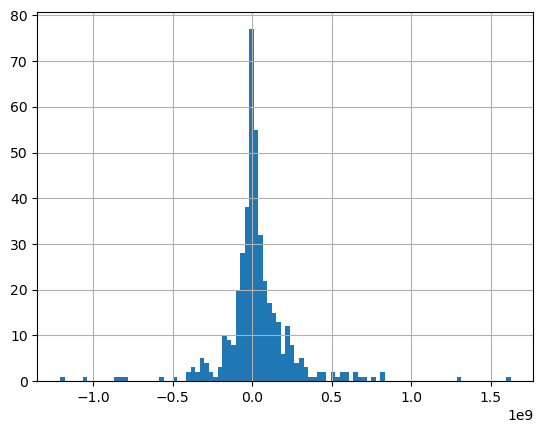

In [241]:
total_rev, book_perc = gu.create_histogram_matching(X_not_book, X_book, pairs)

In [242]:
df_boxplot = pd.DataFrame()
df_boxplot['NOB'] = X_not_book["notnorm_revenue"][[pairs[i][1] for i in range(len(pairs))]].reset_index(drop=True)
df_boxplot["BOB"] = X_book["notnorm_revenue"][np.sort([pairs[i][0] for i in range(len(pairs))])].reset_index(drop=True)
fig = px.box(df_boxplot, x=['NOB', 'BOB'], title='Revenue of NOB and BOB that were matched', labels={"variable":"", "value":'Revenue [$]'})
fig.update_layout(xaxis_type='log')
fig.show()

In [243]:
quizz_films = gu.extract_films_quizz(X_not_book, X_book,pairs, total_rev, book_perc,10)
display(quizz_films)

,BOB Title,NOB Title,Difference,BOB Revenue,NOB Revenue
0,Gone with the Wind,Cinderella,8.233814e+08,6.848513e+09,2.592865e+09
1,Jaws,Mulan,6.876929e+08,2.070373e+09,4.419627e+08
2,Pinocchio,Saw,-2.051211e+08,1.424642e+09,1.302373e+08
3,The Lord of the Rings: The Fellowship of the Ring,Pulp Fiction,-3.055471e+08,1.165010e+09,3.416284e+08
4,Love Story,Melancholia,1.909370e+07,8.317016e+08,1.678263e+07
5,Song of the South,The Bride Wore Red,-1.061704e+09,7.884467e+08,1.975087e+07
6,Dances with Wolves,Raging Bull,1.439161e+08,7.686121e+08,6.607259e+07
7,Harry Potter and the Goblet of Fire,The Wolf of Wall Street,-8.822760e+05,1.086052e+09,3.983591e+08
8,The Da Vinci Code,The Social Network,-3.638442e+08,9.016785e+08,2.441891e+08
9,Jaws 2,Dredd,-8.251516e+07,6.818437e+08,4.231435e+07


## Extraction Most Important Features

For the final analysis of important features we used both book and movie features combined with the similarity score between summaries of books and movies. 

In [244]:
#This function can be used to merge the dataset with the similarity scores. 
#Since there are a lot of Nan values in the similarity column, the nan values are dropped. If we want to do it on the entire dataset, books_movies_adj can be merged directly with the book genres. 
merged_df = merge_and_clean_sim(df_revenue)

In [245]:
book_ids = merged_df[['book_id', 'movie_id', 'tmdb_id', 'adjusted_revenue', 'adjusted_budget', 'movie_year', 'runtime_y',  'film_sentiment', 'film_sentiment_score', 'book_sentiment', 'book_sentiment_score', 'similarity']]

book_genres = pd.read_csv('./data/book_genres.csv')
book_genres_df = book_genres.groupby('book_id')['genre'].apply(lambda x: ', '.join(x)).reset_index()
book_sim_genres = book_ids.merge(book_genres_df[['book_id', 'genre']], on= 'book_id', how= 'inner')
books_df_final = books_features_preprocessing(book_sim_genres=book_sim_genres)

In [246]:
books_df_final.drop(columns=['movie_id', 'book_id', 'title', 'series', 'series_num', 'author', 'description', 'cover_image', 'five_stars', 'four_stars', 'three_stars', 'two_stars', 'one_star'], inplace=True)
books_regression = multi_one_hot_encode_columns(
    books_df_final,
    column_names_mohe=['genre'], 
    threshold=50,
    column_names_ohe=['book_sentiment', 'film_sentiment']
)
book_values_df = books_regression[['three_stars_percentage', 'rating_count', 'genre_Thriller', 'part_of_series',
 'review_count' ,'genre_Adventure' ,'five_stars_percentage',
 'normalized_rating' ,'year', 'book_sentiment_positive', 'book_sentiment_score', 'similarity', 'tmdb_id', 'film_sentiment_positive', 'film_sentiment_score', 'adjusted_budget', 'adjusted_revenue', 'runtime_y', 'movie_year']].copy()
book_values_df.rename(columns={'tmdb_id':'id'}, inplace=True)


In [247]:
# here we can use the regression dataset processed before for linear regression
final_regression_df = book_values_df.merge(final_regression_dataset[["vote_average", "vote_count", "popularity", "genres_Adventure", "genres_count", "id"]], on= 'id', how= 'inner')
final_regression_df.drop(columns=['id'], inplace=True)
final_regression_df.rename(columns={'rating_count':'book_rating_count', 'review_count':'book_review_count', 'genre_Adventure':'book_genre_adventure', 'genre_Thriller':'book_genre_thriller', 'normalized_rating':'book_normalized_rating', 'year':'book_year', 'runtime_y':'movie_runtime', 'vote_average':'movie_vote_average', 'vote_count':'movie_vote_count', 'popularity':'movie_popularity', 'film_sentiment_positive':'movie_sentiment_positive', 'film_sentiment_score':'movie_sentiment_score', 'genres_Adventure':'movie_genre_adventure', 'genres_count':'movie_genres_count', 'three_stars_percentage':'book_3_stars_percentage', 'part_of_series':'book_in_series', 'five_stars_percentage':'book_5_starts_percentage', 'adjusted_revenue':'movie_adjusted_revenue', 'adjusted_budget':'movie_adjusted_budget'}, inplace=True)
final_regression_df['sentiment_difference'] = final_regression_df['movie_sentiment_score'] - final_regression_df["book_sentiment_score"]

In [248]:
split_dict = create_train_test_split(
    final_regression_df,
    target_column='movie_adjusted_revenue',
    should_split_based_on_book=False,
    test_size=0.2,
    seed=42
)
X_train, X_test, y_train, y_test = split_dict['all']

In [249]:
model = sm.OLS(y_train, X_train)
results = model.fit()

y_pred = results.predict(X_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=y_pred)
print("RMSE value:", rmse)

results_summary = results.summary()
results.summary()

RMSE value: 734464420.2763523


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     17.26
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           1.17e-40
Time:                        19:09:43   Log-Likelihood:                -6426.0
No. Observations:                 313   AIC:                         1.290e+04
Df Residuals:                     290   BIC:                         1.298e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     2.073e+08   1.17e+07     17.694      0.000    1.84e+08     2.3e+08
book_3_stars_percentage    5.71e+07   4.54e+07      1.258      0.209   -3.22e+07    1.46e+08
book_rating_count         6.288e+06   3.82e+07      0.165      0.869   -6.89e+07    8.15e+07
book_genre_thriller       3.526e+07   1.35e+07      2.613      0.009     8.7e+06    6.18e+07
book_in_series            4.441e+07    1.3e+07      3.416      0.001    1.88e+07       7e+07
book_review_count        -1.787e+07   3.57e+07     -0.500      0.617   -8.82e+07    5.24e+07
book_genre_adventure      3.502e+07   1.57e+07      2.235      0.026    4.19e+06    6.59e+07
book_5_starts_percentage  3.562e+07   5.02e+07      0.710      0.478   -6.31e+07    1.34e+08
book_normalized_rating     1.02e+06   3.91e+07      0.026      0.979    -7.6e+07     7.8e+07
book_year                 4.647e+06   1.27e+07      0.366      0.715   -2.04e+07    2.96e+07
book_sentiment_positive   6.399e+06    2.3e+07      0.279      0.781   -3.88e+07    5.16e+07
book_sentiment_score      1.335e+06   1.73e+07      0.077      0.939   -3.28e+07    3.54e+07
similarity                2.331e+07   1.28e+07      1.818      0.070   -1.92e+06    4.85e+07
movie_sentiment_positive  3.988e+06   2.11e+07      0.189      0.850   -3.75e+07    4.55e+07
movie_sentiment_score    -3.987e+06   1.52e+07     -0.263      0.793   -3.38e+07    2.58e+07
movie_adjusted_budget     6.698e+07   1.53e+07      4.379      0.000    3.69e+07    9.71e+07
movie_runtime             2.001e+07   1.28e+07      1.560      0.120   -5.24e+06    4.53e+07
movie_year               -4.602e+07   1.42e+07     -3.252      0.001   -7.39e+07   -1.82e+07
movie_vote_average        1.393e+07   1.75e+07      0.796      0.427   -2.05e+07    4.84e+07
movie_vote_count          8.352e+07   2.29e+07      3.653      0.000    3.85e+07    1.29e+08
movie_popularity          6.943e+07   2.11e+07      3.287      0.001    2.79e+07    1.11e+08
movie_genre_adventure     2.634e+07   1.69e+07      1.558      0.120   -6.94e+06    5.96e+07
movie_genres_count       -3.382e+07   1.36e+07     -2.492      0.013   -6.05e+07   -7.11e+06
sentiment_difference     -4.469e+06   1.16e+07     -0.386      0.700   -2.73e+07    1.83e+07
==============================================================================
Omnibus:                      245.632   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6272.918
Skew:                           2.931   Prob(JB):                         0.00
Kurtosis:                      24.134   Cond. No.                     1.27e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified